In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.colors as mcolors

In [2]:
import matplotlib 
import matplotlib.font_manager as font_manager
try:     
    fe = font_manager.FontEntry(
        fname='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf',
        name='Aria2')
    font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
    matplotlib.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
except:
    # on Ubuntu / WSL it may help to install ttf-mscorefonts-installer from multiverse 
    print("Could not set arial as font. Default font will be used. ")  
    
    
# make editable PDFs     
matplotlib.rcParams['pdf.fonttype'] = 42

# Defining utility functions and constants
Skip to the next section for paper contents


In [3]:
# defining frequently used columns
loccol = "location"
datecol = "Sampling_date"

In [4]:
# a nice tool to do a nice groupby.mean()
def pd_mean_first(
    df, group_by, agg_numeric="mean", exclude_extra=[], extra_transforms={}
):

    """
    It's like groupby, but it does mean() for numeric types and first() for non-numeric.

    Parameters
    ----------

    groupby: what to groupby by?
        fed to pd.groupby() directly
    agg_numeric: str or function
        How to aggregate numeric columns
        Fed to pd.groupby().agg()
    exclude_extra: list (optional)
        Columns on which you groupby should be excluded from the dict
        that you would feed to .groupby().agg()
        Default uses columns on which you .groupby()

        If using pd.Grouper() in group_by, the column which you indicate in Grouper
        will not be excluded out of transforms because you would pass a grouper object, not a string.
        You should specify them here if you use pd.Grouper for groupby.
    extra_transforms: dict (optional)
        Do you want to take .mean() of everything, but .sum() of that one specific column?
        Just specify that specific column there.
        Dict of transforms will be updated with this dict.
    """

    if type(group_by) == str:
        exclude = [group_by]
    else:
        exclude = group_by
    exclude = exclude + exclude_extra
    num = df._get_numeric_data().columns
    cols = df.columns.values

    tran = {}
    for i in cols:
        if i not in exclude:
            if i in num:
                tran[i] = agg_numeric
            else:
                tran[i] = "first"
    tran.update(extra_transforms)

    return df.groupby(group_by).agg(tran).reset_index()

# Standard curves for N1/N2 assay 

This section of the code does: 

* Loading the standard curves 
* Plotting the standard curves
* saving coefficients into stds_n1n2 dictionary 

The standard curve we performed is a 5-step 10-fold dilution curve with 4 replicates.
WT curve was performed twice on two different days (8 replicates total). 
There are 4 curves total, for N1/N2 primer, and for WT /  B.1.1.7 standard. 

The N1/N2 assay we perform should not discriminate between the WT and B.1.1.7 standards. 
However, the two standards may be slightly different. 
To verify that they are comparable, we performed N1/N2 standard curve on WT and B.1.1.7 standards. 

We are using the  N1/N2 standard curve for the WT standard to quantify the SARS-CoV-2 concentration. 

In [5]:
n1n2_curve_data = pd.read_csv("in_data/standard_curve_N1N2.csv")
print("Number of points for primer/standard combinations")
display(n1n2_curve_data.groupby(["primer", "Standard"]).size().reset_index())
n1n2_curve_data.head()

Number of points for primer/standard combinations


,primer,Standard,0
0,N1,B.1.1.7,20
1,N1,WT,40
2,N2,B.1.1.7,20
3,N2,WT,40


,Ct,Standard,primer,copies,technical_replicate
0,23.95,B.1.1.7,N1,30000.0,1
1,27.50,B.1.1.7,N1,3000.0,1
2,30.68,B.1.1.7,N1,300.0,1
3,35.01,B.1.1.7,N1,30.0,1
4,37.58,B.1.1.7,N1,3.0,1


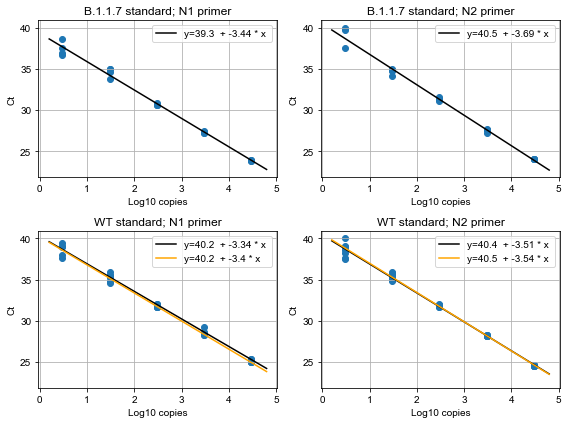

In [6]:
# Calculating standard curves and saving them
stds_n1n2 = {}
plt.figure(figsize=(8, 6))
for ind, (i, subdf) in enumerate(n1n2_curve_data.groupby(["Standard", "primer"])):
    if ind == 0:
        ax = plt.subplot(2, 2, ind + 1)
    else:
        plt.subplot(2, 2, ind + 1, sharex=ax, sharey=ax)
    plt.title(f"{i[0]} standard; {i[1]} primer")

    # drop NA = ignore nondetects that happen in one replicate at 3 copies
    subdf = subdf.dropna()

    # log10 of copies
    lcopies = np.log10(subdf["copies"])
    plt.scatter(lcopies, subdf["Ct"])

    # separating out two replicates
    for tr in [1, 2]:
        mask = subdf["technical_replicate"] == tr
        if mask.sum() == 0:
            continue
        # Ordinary lineaar regression
        lr = scipy.stats.linregress(lcopies.loc[mask], subdf["Ct"].loc[mask])
        x = np.linspace(0.2, 4.8, 20)
        if tr == 1:
            color = "black"
        else:
            color = "orange"
        plt.plot(
            x,
            lr[0] * x + lr[1],
            color=color,
            label=f"y={lr[1]:.3g}  + {lr[0]:.3g} * x ",
        )
    plt.legend()
    plt.grid()
    plt.xlabel("Log10 copies")
    plt.ylabel("Ct")

    # "inverse" regression for calculating copies from Ct values
    lr_inv = scipy.stats.linregress(subdf["Ct"], lcopies)
    # saving this as we would need it
    stds_n1n2[i] = (lr_inv[0], lr_inv[1])
plt.tight_layout()
plt.savefig("figures/N1_N2_standard.pdf")

**Figure N1/N2_standard_curve (above)**
A 5-step 10-fold dilution standard curve for N1/N2 priemrs was run with 4 replicates per concentration. 
The curve was repeated twice for the WT template (black and orange curves), and once for the B.1.1.7 template. 


## Standard curves for AS-qCPR data 

We used a 4-step 10-fold dilution standard curve. Analyses were performed similarly to the N1/N2 standard curve.
The standard curve was performed with 8 replicates, and was repeated twice on two different days. 


In [7]:
asq_curve_data = pd.read_csv("in_data/standard_curve_AS_qpcr.csv")

print("Number of reactions for primer/standard/replicates combinations")
display(
    asq_curve_data.groupby(["Target", "template", "technical_replicate"])
    .size()
    .reset_index()
)

asq_curve_data.head()

Number of reactions for primer/standard/replicates combinations


,Target,template,technical_replicate,0
0,A570D,B.1.1.7,1,32
1,A570D,B.1.1.7,2,32
2,A570D,WT,1,32
3,A570D,WT,2,32
4,HV-69/70-del,B.1.1.7,1,32
5,HV-69/70-del,B.1.1.7,2,32
6,HV-69/70-del,WT,1,32
7,HV-69/70-del,WT,2,32
8,Y144del,B.1.1.7,1,32
9,Y144del,B.1.1.7,2,32


,copies,template,Target,Ct,technical_replicate
0,10000.0,WT,HV-69/70-del,25.91,1
1,1000.0,WT,HV-69/70-del,29.42,1
2,100.0,WT,HV-69/70-del,32.11,1
3,10.0,WT,HV-69/70-del,35.03,1
4,10000.0,B.1.1.7,HV-69/70-del,25.83,1


{('B.1.1.7', 'A570D'): (-0.29491435975949976, 12.061441057589732),
 ('B.1.1.7', 'HV-69/70-del'): (-0.3373373011893826, 12.814812584536035),
 ('B.1.1.7', 'Y144del'): (-0.2685100781510797, 11.019363278036938),
 ('WT', 'A570D'): (-0.2871035812636071, 11.75783542119657),
 ('WT', 'HV-69/70-del'): (-0.3093212928663413, 12.10616607577227),
 ('WT', 'Y144del'): (-0.29442539839093246, 11.846396260014654)}

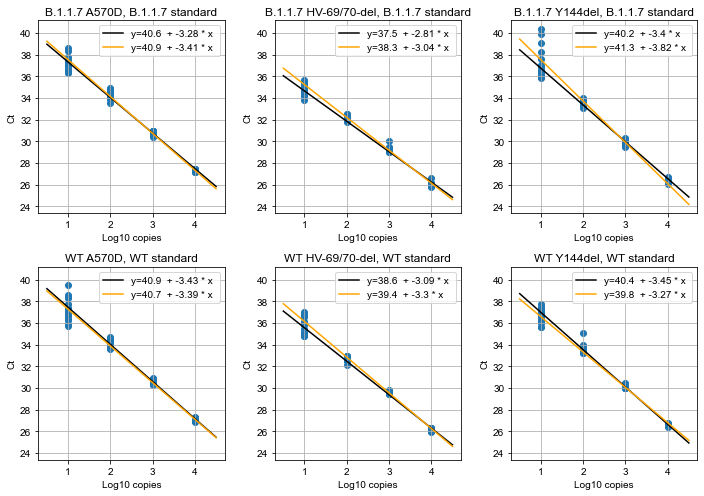

In [8]:
stds_asq = {}
plt.figure(figsize=(10, 7))
for ind, (name, subdf) in enumerate(asq_curve_data.groupby(["template", "Target"])):
    if ind == 0:
        ax = plt.subplot(2, 3, ind + 1)
    else:
        plt.subplot(2, 3, ind + 1, sharex=ax, sharey=ax)
    tg = name[0]
    if tg == "mut":
        tg = "B.1.1.7"
    plt.title(f"{tg} {name[1]}, {tg} standard")
    subdf = subdf.dropna()
    plt.scatter(np.log10(subdf["copies"]), subdf["Ct"])

    # keeping a whole standard curve now 
    
    # removing copies=10 because they are often missing
    # subdf = subdf[subdf["copies"] > 20]
    
    lcopies = np.log10(subdf["copies"])
    for tr in [1, 2]:
        mask = subdf["technical_replicate"] == tr
        lr = scipy.stats.linregress(lcopies.loc[mask], subdf["Ct"].loc[mask])
        x = np.linspace(0.5, 4.5, 20)
        if tr == 1:
            color = "black"
        else:
            color = "orange"
        plt.plot(
            x,
            lr[0] * x + lr[1],
            color=color,
            label=f"y={lr[1]:.3g}  + {lr[0]:.3g} * x ",
        )
    plt.legend()
    plt.grid()
    plt.xlabel("Log10 copies")
    plt.ylabel("Ct")

    lr_inv = scipy.stats.linregress(subdf["Ct"], lcopies)
    stds_asq[name] = (lr_inv[0], lr_inv[1])
plt.tight_layout()
plt.savefig("./figures/ASqpcr_standard.pdf")


stds_asq

## Loading N1/N2qPCR replicates and applying the standard curve

qPCR replicates were obtained as a part of regular Biobot survelliance program. 

Samples are identified by Kit_ID. For all samples, we performed 3 replicates of qPCR for N1 and N2 primers. 

In [9]:
reps = pd.read_csv(
    "in_data/replicates_n1_n2.csv",
)
reps.head()

,Kit_ID,primer,replicate,Cq
0,59739083ca,N1,1.0,35.82
1,59739083ca,N1,2.0,36.39
2,59739083ca,N1,3.0,35.77
3,59739083ca,N2,1.0,35.39
4,59739083ca,N2,2.0,35.85


In [10]:
virus_copies = []
for _, i in reps.iterrows():
    ct = i["Cq"]
    prim = i["primer"]

    st = stds_n1n2[("WT", prim)]
    if (not np.isfinite(ct)) or (ct > 40):
        virus_copies.append(np.nan)
        continue
    cop = 10 ** (st[0] * ct + st[1])
    # 15 ml of sewage volume concentrated to 75uL of RNA and 3uL used for reaction
    conc = cop * 75 / 3 / 15
    virus_copies.append(conc)
reps["virus_copies_per_mL_sewage"] = virus_copies
# nondetects are interpreted as 0 concentration
reps["virus_copies_per_mL_sewage"] = reps["virus_copies_per_mL_sewage"].fillna(0)
reps["conc_n1n2"] = reps.groupby("Kit_ID")["virus_copies_per_mL_sewage"].transform(
    "mean"
)
n1n2_copies = reps.groupby("Kit_ID")["conc_n1n2"].first().reset_index()
print("A table with N1N2 conc (concentration)")
n1n2_copies.head()

A table with N1N2 conc (concentration)


,Kit_ID,conc_n1n2
0,0681d9a7c1,130.249359
1,0a50864c36,223.262849
2,1566e0dd3d,53.823246
3,239463d573,24.936159
4,245a5322c1,16.612420


# Loading AS-qPCR replicates and applying standard curves 

The code cells below do: 
* load the data and merge in the n1/n2 copies 
* Define the time period variable
* "Apply" the standard curves to get virus concentration 
* Define the # of replicates detected per sample
* enforce having at least 2 replicates (out of 6). 
* Average 2 replicates for each variant together, separate WT and B.1.1.7 concentrations into different columns
* Make "scatter" figure and its extended version 

In [11]:
# load the data and merged in n1/n2 copies
df = pd.read_csv("in_data/variant_assay_batch1-batch3.csv", parse_dates=[datecol])
df = pd.merge(
    df,
    n1n2_copies,
    left_on="Kit ID",
    right_on="Kit_ID",
    how="left",
    validate="many_to_one",
)

In [12]:
# defining time period variable
df["time period"] = "Oct 2020"
tp = df["time period"].copy()
tp[df[datecol] > pd.to_datetime("2020-11-30")] = "Jan 2021"
tp[df[datecol] > pd.to_datetime("2021-01-31")] = "Feb-Mar 2021"
df["time period"] = tp
df.head()

,Unnamed: 0,Kit ID,batch,Ct,Assay,replicate,variant,Sampling_date,State,is_building,location,Kit_ID,conc_n1n2,time period
0,0,eda521d80f,1,36.71,WT,1,HV-69/70-del,2021-02-28,CO,False,CO-3195bf5ee3,eda521d80f,65.062766,Feb-Mar 2021
1,1,c685a47b56,1,37.24,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-03792d2da1,c685a47b56,150.735159,Feb-Mar 2021
2,2,27a1301570,1,35.27,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-e639989ec2,27a1301570,224.623462,Feb-Mar 2021
3,3,83a7902a78,1,NaN,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-d1166234ad,83a7902a78,44.794668,Feb-Mar 2021
4,4,52fe71f8e2,1,35.95,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-e8da203597,52fe71f8e2,172.026890,Feb-Mar 2021


In [13]:
# Getting the standards out of the dict defined above
df[["slope", "intr"]] = [stds_asq[(i["Assay"], i["variant"])] for _, i in df.iterrows()]
# Ct >40 are cast to nan
df["Ct"] = [i if i < 40 else np.nan for i in df["Ct"]]
# calculate copies
df["copies"] = 10 ** (df["Ct"] * df["slope"] + df["intr"])  # .fillna(0)
df.pop("slope")
df.pop("intr")
# 1uL is used for reaction, same RNA (concentrated from 15mL sewage to 75uL RNA )
df["conc_asqpcr"] = df["copies"] * 75 / 15
df.head()

,Unnamed: 0,Kit ID,batch,Ct,Assay,replicate,variant,Sampling_date,State,is_building,location,Kit_ID,conc_n1n2,time period,copies,conc_asqpcr
0,0,eda521d80f,1,36.71,WT,1,HV-69/70-del,2021-02-28,CO,False,CO-3195bf5ee3,eda521d80f,65.062766,Feb-Mar 2021,5.636135,28.180677
1,1,c685a47b56,1,37.24,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-03792d2da1,c685a47b56,150.735159,Feb-Mar 2021,3.864036,19.320178
2,2,27a1301570,1,35.27,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-e639989ec2,27a1301570,224.623462,Feb-Mar 2021,15.718246,78.591229
3,3,83a7902a78,1,NaN,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-d1166234ad,83a7902a78,44.794668,Feb-Mar 2021,NaN,NaN
4,4,52fe71f8e2,1,35.95,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-e8da203597,52fe71f8e2,172.026890,Feb-Mar 2021,9.684241,48.421206


In [14]:
# Enforcing at least 1 replicate per assay
copcount = df.groupby(["Assay", "Kit ID"])["conc_asqpcr"].transform("count")

print("---Below are all removed one-replicate samples-----")
df[copcount == 1].sort_values("conc_asqpcr").groupby(
    ["Kit ID", "Assay"]
).first().reset_index()

---Below are all removed one-replicate samples-----


,Kit ID,Assay,Unnamed: 0,batch,Ct,replicate,variant,Sampling_date,State,is_building,location,Kit_ID,conc_n1n2,time period,copies,conc_asqpcr
0,0681d9a7c1,B.1.1.7,713,3,38.95,2,A570D,2021-01-24,CO,False,CO-3195bf5ee3,0681d9a7c1,130.249359,Jan 2021,3.754281,18.771404
1,0a50864c36,WT,246,1,38.90,1,Y144del,2021-03-02,FL,True,FL-492c4a6696,0a50864c36,223.262849,Feb-Mar 2021,2.473137,12.365687
2,27daf66b18,WT,267,2,37.09,1,Y144del,2020-10-28,FL,True,FL-0d899399bb,27daf66b18,11.161251,Oct 2020,8.436421,42.182104
3,2c0201a4c5,B.1.1.7,477,3,39.69,2,Y144del,2021-01-20,OH,False,OH-3d532045ea,2c0201a4c5,179.919668,Jan 2021,2.302493,11.512464
4,63eabe6638,B.1.1.7,211,2,36.23,2,HV-69/70-del,2020-10-28,MA,False,MA-03792d2da1,63eabe6638,120.229650,Oct 2020,3.918160,19.590800
5,83a7902a78,B.1.1.7,123,1,35.80,1,HV-69/70-del,2021-03-03,FL,False,FL-d1166234ad,83a7902a78,44.794668,Feb-Mar 2021,5.471888,27.359440
6,856aadabed,B.1.1.7,174,3,36.14,1,HV-69/70-del,2021-01-25,CT,False,CT-da9b42b2a9,856aadabed,230.968299,Jan 2021,4.201869,21.009346
7,8608df8b8b,B.1.1.7,419,3,39.92,1,Y144del,2021-01-21,MA,False,MA-03792d2da1,8608df8b8b,227.921319,Jan 2021,1.997289,9.986446
8,91c82e4038,B.1.1.7,378,1,38.65,1,Y144del,2021-02-24,MA,False,MA-03304b1aa1,91c82e4038,21.129060,Feb-Mar 2021,4.379744,21.898722
9,9adbfcab1f,B.1.1.7,382,2,38.85,1,Y144del,2020-10-29,FL,True,FL-492c4a6696,9adbfcab1f,1202.921686,Oct 2020,3.870319,19.351594


In [15]:
# making a copy of df with 1-replicate samples removed
df2 = df.copy()
df2["conc_asqpcr"] = df2["conc_asqpcr"].where(copcount > 1, np.nan)
df2.head()

,Unnamed: 0,Kit ID,batch,Ct,Assay,replicate,variant,Sampling_date,State,is_building,location,Kit_ID,conc_n1n2,time period,copies,conc_asqpcr
0,0,eda521d80f,1,36.71,WT,1,HV-69/70-del,2021-02-28,CO,False,CO-3195bf5ee3,eda521d80f,65.062766,Feb-Mar 2021,5.636135,28.180677
1,1,c685a47b56,1,37.24,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-03792d2da1,c685a47b56,150.735159,Feb-Mar 2021,3.864036,19.320178
2,2,27a1301570,1,35.27,WT,1,HV-69/70-del,2021-03-08,MA,False,MA-e639989ec2,27a1301570,224.623462,Feb-Mar 2021,15.718246,78.591229
3,3,83a7902a78,1,NaN,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-d1166234ad,83a7902a78,44.794668,Feb-Mar 2021,NaN,NaN
4,4,52fe71f8e2,1,35.95,WT,1,HV-69/70-del,2021-03-03,FL,False,FL-e8da203597,52fe71f8e2,172.026890,Feb-Mar 2021,9.684241,48.421206


In [16]:
# Creating df3 - variant_assay table,  averaged over replicates
# average over location-date-target-assay, then put B.1.1.7 and WT copies as two columns
df_av = pd_mean_first(df2, [loccol, datecol, "variant", "Assay"])

df_wt = df_av.query("Assay=='WT'")
df_mut = df_av.query("Assay=='B.1.1.7'")

df_mut = df_mut[[loccol, datecol, "variant", "conc_asqpcr"]].rename(
    {"conc_asqpcr": "conc_mut"}, axis=1
)
df_wt = pd.merge(df_wt, df_mut)
# purging unnecessary columns
for i in ["Kit_ID", "replicate", "batch", "Kit ID", "copies"]:
    if i in df_wt:
        df_wt.pop(i)
# rename conc_wt
df_wt["conc_wt"] = df_wt.pop("conc_asqpcr")
df3 = df_wt.copy()
df3["conc_both"] = df3[["conc_wt", "conc_mut"]].sum(axis=1)
df3.tail()

,location,Sampling_date,variant,Assay,Unnamed: 0,Ct,State,is_building,conc_n1n2,time period,conc_mut,conc_wt,conc_both
169,VA-451d253c49,2021-01-26,HV-69/70-del,WT,78,33.285,VA,False,707.874535,Jan 2021,NaN,323.722014,323.722014
170,VA-451d253c49,2021-01-26,Y144del,WT,318,35.255,VA,False,707.874535,Jan 2021,NaN,147.059741,147.059741
171,VA-451d253c49,2021-03-02,A570D,WT,526,35.235,VA,False,404.504450,Feb-Mar 2021,32.868548,219.135688,252.004237
172,VA-451d253c49,2021-03-02,HV-69/70-del,WT,46,34.425,VA,False,404.504450,Feb-Mar 2021,12.388626,145.312668,157.701295
173,VA-451d253c49,2021-03-02,Y144del,WT,286,35.245,VA,False,404.504450,Feb-Mar 2021,42.338220,159.916172,202.254392


SpearmanrResult(correlation=0.671936917441116, pvalue=3.3302576340370365e-24)
SpearmanrResult(correlation=0.44377913867269286, pvalue=8.611164169274786e-10)
SpearmanrResult(correlation=0.8242355782251587, pvalue=2.417384190796554e-44)


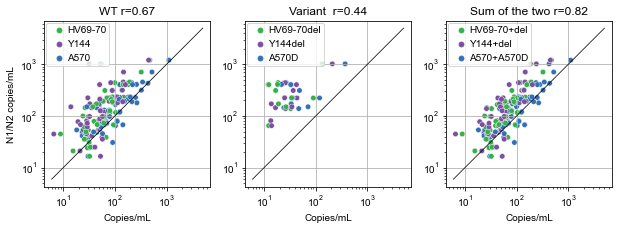

In [44]:
# Making of the "scatter" figure
plt.figure(figsize=(8.7,4))

vals = [df3["conc_wt"].fillna(0), df3["conc_mut"].fillna(0), df3["conc_both"].fillna(0)]

df3[["conc_wt", "conc_mut", "conc_both", "conc_n1n2", "variant"]].to_csv(
    "derived_figure_data/data_scatter.csv", index=None
)
titles = ["WT", "Variant ", "Sum of the two"]

for j, (val, tit) in enumerate(zip(vals, titles)):
    plt.subplot(1, 3, j + 1)
    plt.title(f'{tit} r={val.corr(df3["conc_n1n2"], "spearman"):.2g}')
    val.name = 0
    tm = val.to_frame().join(df3)[[0, "conc_n1n2"]].dropna()
    print(scipy.stats.spearmanr(tm[0], tm["conc_n1n2"]))
    if j == 1:
        hue = df3["variant"].replace(
            {"HV-69/70-del": "HV69-70del", "A570D": "A570D", "Y144": "Y144del"}
        )
    elif j == 2:
        hue = df3["variant"].replace(
            {
                "HV-69/70-del": "HV69-70+del",
                "A570D": "A570+A570D",
                "Y144del": "Y144+del",
            }
        )
    else:
        hue = df3["variant"].replace(
            {"HV-69/70-del": "HV69-70", "A570D": "A570", "Y144del": "Y144"}
        )
    hues = sorted(set(hue))
    hues = [hues[i] for i in [1, 2, 0]]
    g = sns.scatterplot(
        x=val,
        y=df3["conc_n1n2"],
        hue=hue,
        palette=[
            "#35B04A",
            "#7C50A0",
            "#3270B8",
        ],
        hue_order=hues,
        s=30
    )
    plt.legend(loc='upper left',  markerscale=0.8, handletextpad=-.2, borderaxespad=.2, borderpad=.3, columnspacing=0.5)
    plt.xlabel("Copies/mL")
    if j == 0:
        plt.ylabel("N1/N2 copies/mL")
    else:
        plt.ylabel(None)
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(*[[6, 5000]] * 2, color="black", linewidth=0.75)
    plt.gca().set_aspect(1)
    plt.grid()

    plt.tight_layout()
plt.savefig("figures/scatterplots.pdf")

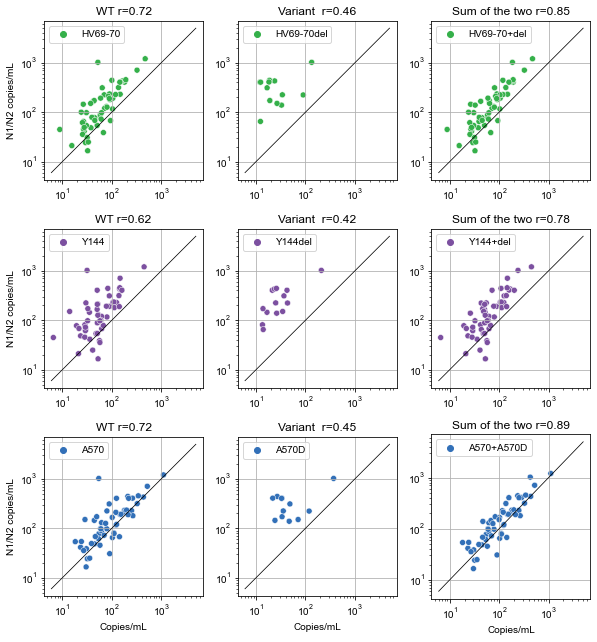

In [47]:
# "Extended" scatter figure
plt.figure(figsize=(8.4, 9))

for ind2, j2 in enumerate([1, 2, 0]):
    for j, (val, tit) in enumerate(zip(vals, titles)):
        plt.gca().set_aspect(1)
        val = val.copy()
        ind = 3 * ind2 + j + 1
        plt.subplot(3, 3, ind)
        val.name = None
        tm = val.to_frame().join(df3)[[0, "conc_n1n2"]].dropna()

        if j == 1:
            hue = df3["variant"].replace(
                {"HV-69/70-del": "HV69-70del", "A570D": "A570D", "Y144": "Y144del"}
            )
        elif j == 2:
            hue = df3["variant"].replace(
                {
                    "HV-69/70-del": "HV69-70+del",
                    "A570D": "A570+A570D",
                    "Y144del": "Y144+del",
                }
            )
        else:
            hue = df3["variant"].replace(
                {"HV-69/70-del": "HV69-70", "A570D": "A570", "Y144del": "Y144"}
            )

        hor = sorted(set(hue.values))

        mask = hue == hor[j2]
        val = val[mask]
        hue = hue[mask]
        df3_use = df3[mask]

        plt.title(f'{tit} r={val.corr(df3_use["conc_n1n2"], "spearman"):.2g}')

        hor_use = hor[j2 : j2 + 1]
        palette = ["#3270B8", "#35B04A", "#7C50A0"]
        palette = palette[j2 : j2 + 1]

        sns.scatterplot(
            x=val,
            y=df3_use["conc_n1n2"],
            hue=hue,
            hue_order=hor_use,
            palette=palette,
            ax=plt.gca(),
        )
        plt.legend(loc="upper left")
        if j2 == 0:
            plt.xlabel("Copies/mL")
        if j == 0:
            plt.ylabel("N1/N2 copies/mL")
        else:
            plt.ylabel(None)
        plt.xscale("log")
        plt.yscale("log")
        plt.plot(*[[6, 5000]] * 2, color="black", linewidth=0.75)

        plt.grid()

        plt.tight_layout()
    plt.savefig("figures/scatterplots_grid.pdf")

# Making plots with heatmaps 

First making necessary pivots 
Pivoted data is saved as an input for figure with heatmaps

In [19]:
pvt_wt = (
    df3.groupby(["time period", loccol, "variant"])
    .mean()
    .reset_index()
    .pivot(index=loccol, columns=["time period", "variant"], values="conc_wt")
)
pvt_mut = (
    df3.groupby(["time period", loccol, "variant"])
    .mean()
    .reset_index()
    .pivot(index=loccol, columns=["time period", "variant"], values="conc_mut")
)
pvt_both = (
    df3.groupby(["time period", loccol, "variant"])
    .mean()
    .reset_index()
    .pivot(index=loccol, columns=["time period", "variant"], values="conc_both")
)

# n1n2 is the same for all targets, just get one of them
pvt_n1n2 = (
    df3.query("variant=='A570D'")
    .groupby(["time period", loccol])
    .mean()
    .reset_index()
    .pivot(index=loccol, columns=["time period"], values="conc_n1n2")
)

print("copies WT + B.1.1.7", end="")
display(pvt_both.head(3))
print("\n copies N1N2", end="")
display(pvt_n1n2.head(3))

# saving figure data
writer = pd.ExcelWriter("derived_figure_data/figure_heatmap_data.xlsx")

# Write each dataframe to a different worksheet.
pvt_wt.to_excel(writer, sheet_name="Wildtype copies")
pvt_mut.to_excel(writer, sheet_name="B.1.1.7 copies")
pvt_both.to_excel(writer, sheet_name="Wildtype + B.1.1.7 copies")
pvt_n1n2.to_excel(writer, sheet_name="N1N2 copies")

writer.save()

copies WT + B.1.1.7

time period   Feb-Mar 2021                            Jan 2021               \
variant              A570D HV-69/70-del    Y144del       A570D HV-69/70-del   
location                                                                      
CA-e1627b9549   110.192443    57.619686  42.083527  146.657782   105.034649   
CO-3195bf5ee3   102.764444    39.136229  43.636774   62.100904    78.051275   
CT-da9b42b2a9    54.833637    44.782609  19.352011  179.887723   147.819692   

time period                  Oct 2020                          
variant           Y144del       A570D HV-69/70-del    Y144del  
location                                                       
CA-e1627b9549   89.246367   44.742280    37.907441  23.406546  
CO-3195bf5ee3   53.231109  122.522348   103.354998  79.795413  
CT-da9b42b2a9  105.326140   18.276611    30.688704  47.937965


 copies N1N2

time period,Feb-Mar 2021,Jan 2021,Oct 2020
location,,,
CA-e1627b9549,81.107959,191.548267,48.428552
CO-3195bf5ee3,65.062766,130.249359,116.656275
CT-da9b42b2a9,77.673618,230.968299,53.823246


In [20]:
# Making a table with names, state-based names, N1N2 copies and building status
# Ordering of columns in heatmaps is set here as well
# Using SARS-CoV-2 concentration from N1-N2 assay in Feb-Mar 2021
conc_n1n2 = pvt_n1n2[("Feb-Mar 2021")]
conc_n1n2.name = "copies"

nametostate = df3[[loccol, "State", "is_building"]].drop_duplicates()
conc_n1n2 = conc_n1n2.to_frame().join(nametostate.set_index(loccol))

states = conc_n1n2["State"]
stnames = (
    pd.DataFrame({"X": states})
    .groupby("X")["X"]
    .transform(lambda x: [f"{x.iloc[0]}-{i+1}" for i in range(len(x))])
)
conc_n1n2["State-based name"] = stnames

conc_n1n2 = conc_n1n2.sort_values(["is_building", "copies"], ascending=[True, False])
conc_n1n2

,copies,State,is_building,State-based name
location,,,,
VA-451d253c49,404.504450,VA,False,VA-1
NY-d535baa7ac,311.491287,NY,False,NY-1
MA-e639989ec2,224.623462,MA,False,MA-3
OH-3d532045ea,210.308921,OH,False,OH-2
FL-e8da203597,172.026890,FL,False,FL-6
MA-03792d2da1,150.735159,MA,False,MA-2
FL-26d9107c06,144.885214,FL,False,FL-2
CA-e1627b9549,81.107959,CA,False,CA-1
CT-da9b42b2a9,77.673618,CT,False,CT-1


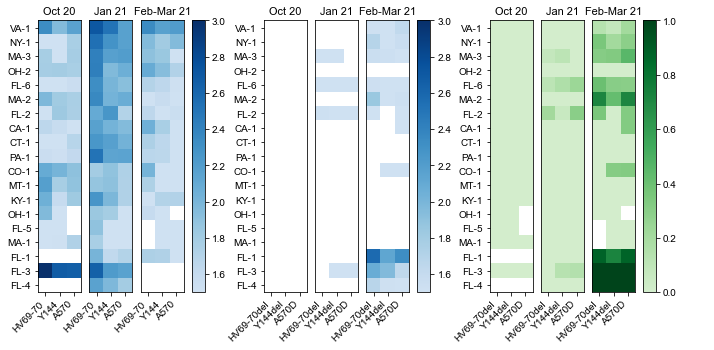

In [30]:
# making final plot

# defining variables we will be using
v1 = pvt_wt.loc[conc_n1n2.index].values
v2 = pvt_mut.loc[conc_n1n2.index].values
v3 = (pvt_mut.fillna(0) / pvt_both).loc[conc_n1n2.index].values
# ratio is undefined if there is no B.1.1.7 or WT
# but defined if one of them is present
v3[(~np.isfinite(v1)) * (~np.isfinite(v2))] = np.nan

titles = ["Oct 20", "Jan 21", "Feb-Mar 21"]

fig, sp = plt.subplots(
    ncols=15, gridspec_kw={"width_ratios": [10, 10, 10, 3,10] * 3}, figsize=(12,5)
)
for i in [4, 9, 14]:  # empty +space after colorbar
    sp[i].axis("off")

for ind, vals in enumerate([v1, v2, v3]):
    for sp_ind in range(3):
        ax = sp[sp_ind + ind * 5]
        plt.sca(ax)
        plt.title(titles[sp_ind], fontsize=11)

        # defining colormaps and vmin/vmax
        if ind in [0, 1]:
            colors = plt.cm.Blues(np.linspace(0.2, 1, 100))
            # colors = np.vstack(([[1, 1, 1, 1]]*9, [[.7,.7, .7, 1]]*10,  colors))
            cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
            vmin, vmax = 1.5, 3
        else:
            colors = plt.cm.Greens(np.linspace(0.2, 1, 100))
            # colors = np.vstack(([[1, 1, 1, 1]]*9, [[.7,.7, .7, 1]]*10,  colors))
            cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
            vmin, vmax = 0, 1

        # selecting values to plot
        st = 2 - sp_ind
        if ind in [0, 1]:
            toshow = np.log10(vals[:, st * 3 : st * 3 + 3] + 1e-10)
        else:
            toshow = vals[:, st * 3 : st * 3 + 3]

        # actual plotting of heatmap
        im = plt.imshow(toshow, vmin=vmin, vmax=vmax, cmap=cmap)
        # dealing with ticks
        stnames = conc_n1n2["State-based name"]
        if sp_ind == 0:
            plt.yticks(range(len(states)), stnames)
        else:
            plt.yticks([])
        if ind == 0:
            ticks = ["HV69-70", "Y144", "A570"]
        else:
            ticks = ["HV69-70del", "Y144del", "A570D"]
        plt.xticks([0, 1, 2], ticks, rotation=45, ha="right")

        # adding colorbar after the last plot
        if sp_ind == 2:
            # cb = plt.colorbar(label="log10 B.1.1.7 concentration", cax = sp[sp_ind+1])
            plt.colorbar(im, cax=sp[sp_ind + 1 + ind * 5])
        else:
            pass

plt.savefig("./figures/heatmaps.pdf")